In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

from scipy.stats import multivariate_normal

In [3]:
os.chdir('..')
!pwd

/Users/admin/Documents/Research/SSL/matrixssl-inductive


In [3]:
from data.loader import generate_correlated_normal_augs

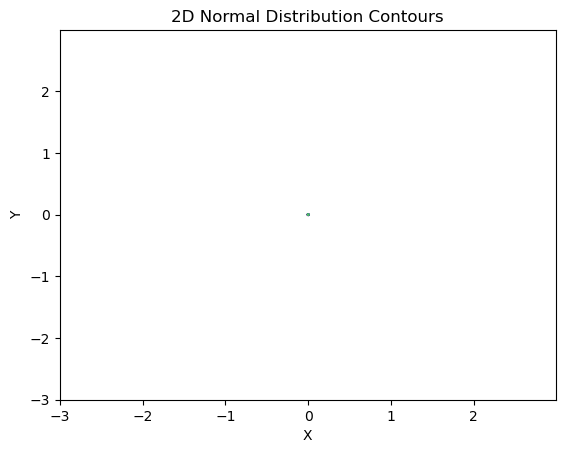

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# Mean vector and covariance matrix
mu = np.zeros(2)
while True:
    vec = np.random.randn(2)
    cov = np.outer(vec, vec)
    if np.all(np.eigval(cov) >= 0):
        break

# Create a grid of (x, y) points
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# Multivariate normal distribution
rv = multivariate_normal(mu, cov, allow_singular=True)

# Plotting the contours
plt.contour(x, y, rv.pdf(pos))
plt.title('2D Normal Distribution Contours')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
d=2
for i in range (100000):
    testvec = torch.rand(d)
    normalized = testvec / torch.linalg.vector_norm(testvec)
    const = 0.5
    off_diag = const * torch.outer(normalized, normalized)
    testcov = torch.eye(2*d)
    testcov[d:, :d] = off_diag
    testcov[:d, d:] = off_diag
    assert (torch.linalg.eigvals(testcov).real > 0).all()
print('done')

done


In [10]:
# Create a grid of (x, y) points
distr = multivariate_normal(np.zeros(d), cov=testcov)
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# Plotting the contours
start = -3 * normalized
end  = 3 * normalized
plt.plot([start[0], end[0]], [start[1], end[1]])
plt.plot([0, normalized[0]], [0, normalized[1]], color='red')
plt.contour(x, y, distr.pdf(pos))
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

ValueError: Dimension mismatch: array 'cov' is of shape (4, 4), but 'mean' is a vector of length 2.

In [24]:
def generate_valid_cov(d=2):
    # valid means [[I cvvT] [cvvT I]] being PSD
    const = 0.9
    vec = torch.randn(d)
    vec = vec / torch.linalg.vector_norm(vec)
    if torch.abs(const * (torch.norm(vec) ** 2)) < 1: # covariance of joint distr of augs is valid (PSD)
        off_diag = const * torch.outer(vec, vec)
        cov = torch.eye(2*d)
        cov[d:, :d] = off_diag
        cov[:d, d:] = off_diag
    return const, vec, cov

Constant: 0.9
Sample: [ 0.85579131 -0.79267961]
Projection: [ 0.07433823 -0.77975329]


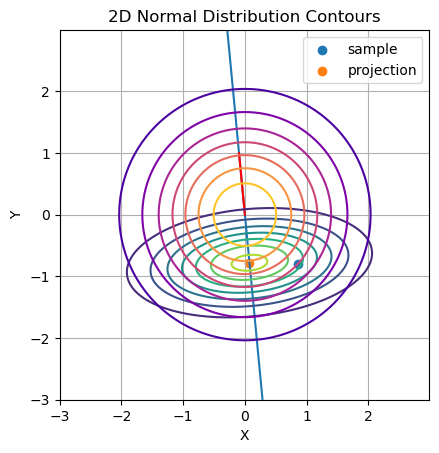

In [27]:
const, vec, cov = generate_valid_cov(d=2)
mu = np.array([0, 0])
rv = multivariate_normal(mu, np.eye(2))
sample = rv.rvs(size=1)
cvvT = const * np.outer(vec, vec)
conditional_mvn = multivariate_normal(cvvT @ sample, cov=np.eye(2)-(cvvT @ cvvT))
# conditional_mvn = multivariate_normal(np.zeros(2), cov=np.eye(2)-(cvvT @ cvvT)) # view centered for eyeballing
std_mvn = multivariate_normal(np.zeros(2), np.eye(2))

# Create a grid of (x, y) points
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

projection = cvvT @ sample
print(f'Constant: {const}')
print(f"Sample: {sample}")
print(f"Projection: {projection}")

# Plotting the contours
start = -3 * vec
end  = 3 * vec
plt.plot([start[0], end[0]], [start[1], end[1]])
plt.plot([0, vec[0]], [0, vec[1]], color='red')
plt.contour(x, y, conditional_mvn.pdf(pos))
plt.contour(x, y, std_mvn.pdf(pos), cmap='plasma')
plt.scatter(sample[0], sample[1], label='sample')
plt.scatter(projection[0], projection[1], label='projection')
plt.title('2D Normal Distribution Contours')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [10]:
samples[3, :]

tensor([-0.0481,  2.0798, -1.6425, -0.2457])

## Simulations to test whether MSSL (centered) assumptions hold or not.
Recall that the assumption is that $Wxx^\top W^\top = W(I -(cvv^\top)^2 + (cvv^\top)(cvv^\top)^\top)W^\top$. 

Below we will first test the more basic assumption $xx^\top = I -(cvv^\top)^2 + (cvv^\top)(cvv^\top)^\top$

In [57]:
# function for adding text
def add_text(matrix, ax):
    for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = ax.text(j, i, f"{matrix[i, j]:.2f}",
                    ha="center", va="center", color="w")

In [75]:
# first, fix some c, v
d=2
c, v, cov = generate_valid_cov(d=d)

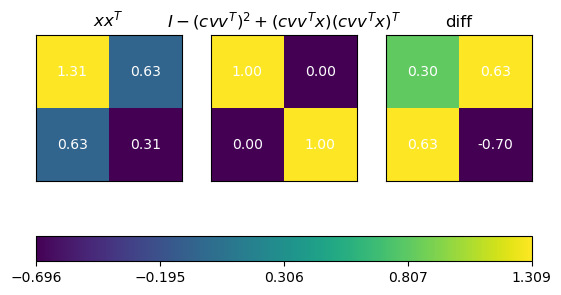

c: 0.9584760069847107, v: tensor([-0.2697, -0.2623])
x ~ N(0, I): tensor([-1.1440, -0.5548])


In [76]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# then fix x ~ N(0, I)
std_mvn = MultivariateNormal(loc=torch.zeros(d), covariance_matrix=torch.eye(d))
x = std_mvn.sample(())


# plot squared difference of weight matrices..
fig, ax = plt.subplots(1, 3) # 1: xxT, 2: RHS, 3: squared difference
xxT = torch.outer(x, x)
im0 = ax[0].imshow(xxT)
add_text(xxT, ax[0])
ax[0].set_title("$xx^T$")

cvvT = c * torch.outer(v, v)
cvvTx = cvvT @ x
rhs = torch.eye(d) - (cvvT @ cvvT) + torch.outer(cvvTx, cvvTx)
im1 = ax[1].imshow(rhs)
add_text(rhs, ax[1])
ax[1].set_title("$I - (cvv^T)^2 + (cvv^T x)(cvv^T x)^T$")

diff = xxT - rhs
im2 = ax[2].imshow(diff)
add_text(diff, ax[2])
ax[2].set_title("diff")

vmin = min(im.get_array().min() for im in [im0, im1, im2])
vmax = max(im.get_array().max() for im in [im0, im1, im2])
# Create a ScalarMappable with the combined range
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=im1.get_cmap(), norm=norm)
sm.set_array([])

# Add the colorbar using this ScalarMappable
cbar = fig.colorbar(sm, ax=ax, location='bottom', orientation='horizontal')
for axes in fig.get_axes():
    axes.set_xticks([])
    axes.set_yticks([])
cbar_ax = ax[:]
nticks = 5
ticks = np.linspace(vmin, vmax, nticks)
cbar.set_ticks(ticks)
plt.show()

print(f"c: {c.item()}, v: {v}")
print(f"x ~ N(0, I): {x}")

c: 0.9584760069847107, v: tensor([-0.2697, -0.2623])
x ~ N(0, I): tensor([ 0.7485, -0.0867])


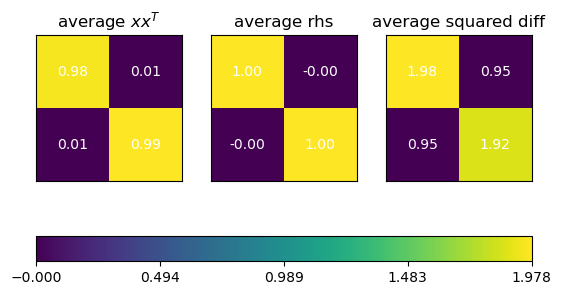

In [78]:
n = 10000
std_mvn = MultivariateNormal(loc=torch.zeros(d), covariance_matrix=torch.eye(d))

xxT_avg = torch.zeros((d, d))
rhs_avg = torch.zeros((d, d))
sq_diff_avg = torch.zeros((d,d))

for i in range(n):
    x = std_mvn.sample(())
    xxT = torch.outer(x, x)
    cvvT = c * torch.outer(v, v)
    cvvTx = cvvT @ x
    rhs = torch.eye(d) - (cvvT @ cvvT) + torch.outer(cvvTx, cvvTx)
    sq_diff = (xxT - rhs) ** 2

    xxT_avg += xxT
    rhs_avg += rhs
    sq_diff_avg += sq_diff
xxT_avg = xxT_avg / n
rhs_avg = rhs_avg / n
sq_diff_avg = sq_diff_avg / n

fig, ax = plt.subplots(1, 3)
im0 = ax[0].imshow(xxT_avg)
add_text(xxT_avg, ax[0])
ax[0].set_title("average $xx^T$")

im1 = ax[1].imshow(rhs_avg)
add_text(rhs_avg, ax[1])
ax[1].set_title("average rhs")

im2 = ax[2].imshow(sq_diff_avg)
add_text(sq_diff_avg, ax[2])
ax[2].set_title("average squared diff")

vmin = min(im.get_array().min() for im in [im0, im1, im2])
vmax = max(im.get_array().max() for im in [im0, im1, im2])
# Create a ScalarMappable with the combined range
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=im1.get_cmap(), norm=norm)
sm.set_array([])

# Add the colorbar using this ScalarMappable
cbar = fig.colorbar(sm, ax=ax, location='bottom', orientation='horizontal')
for axes in fig.get_axes():
    axes.set_xticks([])
    axes.set_yticks([])
cbar_ax = ax[:]
nticks = 5
ticks = np.linspace(vmin, vmax, nticks)
cbar.set_ticks(ticks)

print(f"c: {c.item()}, v: {v}")
print(f"x ~ N(0, I): {x}")

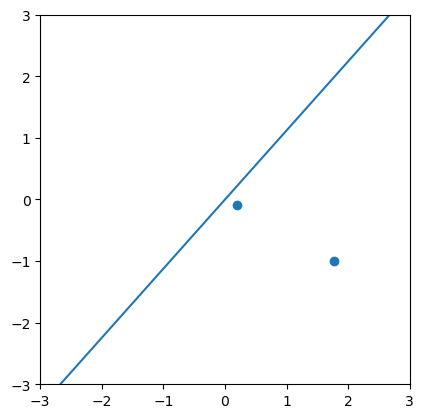

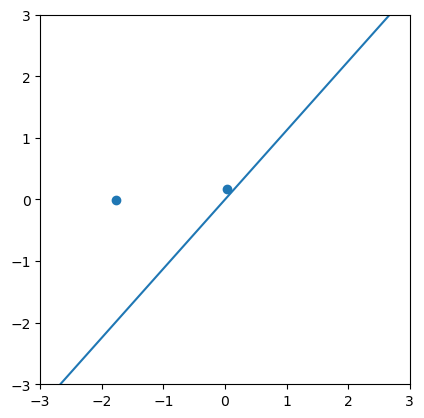

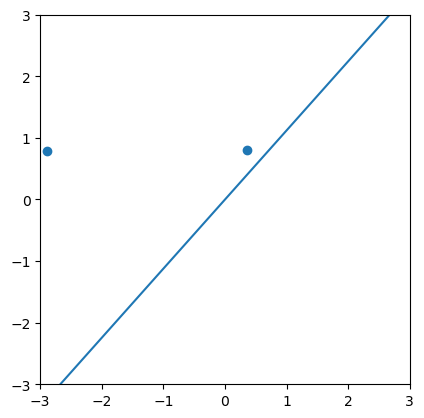

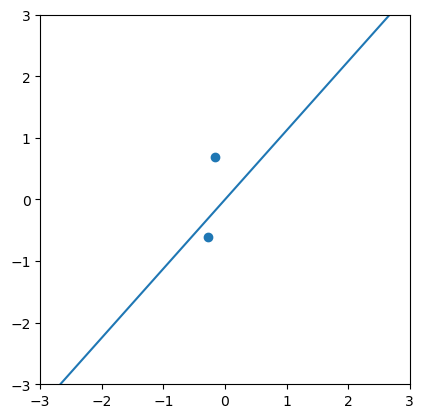

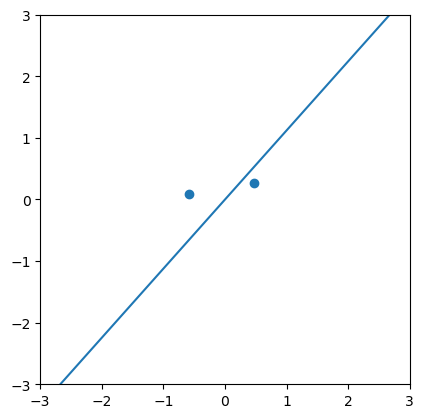

In [14]:
d = 2
n = 5
vec, cov = generate_valid_cov(d=d)
mvn = MultivariateNormal(torch.zeros(4), cov)
samples = mvn.sample((n,))  
for i in range(n):
    plt.figure()
    x1, x2 = samples[i, :d], samples[i, d:]
    start = -5 * vec
    end  = 5 * vec
    plt.plot([start[0], end[0]], [start[1], end[1]])
    plt.scatter([x1[0], x2[0]], [x1[1], x2[1]])
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
plt.show()


In [19]:
# retry until we get a PSD covariance matrix
def generate_valid_direction(d=4):
    while True:
        const = torch.rand(1)
        vec = torch.randn(d)

        #
        # outer = torch.outer(vec, vec)
        # off_diag = const * outer
        # cov = torch.eye(2*d)
        # cov[:d, d:] = outer
        # cov[d:, :d] = outer
        # if (torch.linalg.eigvals(cov).real > 0).all():
        #     break
        #
        if torch.abs(const * (torch.norm(vec) ** 2)) < 1:
            break
    return const, vec

const_list = []
dir_list = []
for i in range(3):
    const, vec = generate_valid_direction(d=6)
    dir_list.append(vec)
    const_list.append(const)

Text(0, 0.5, 'Dimension 5')

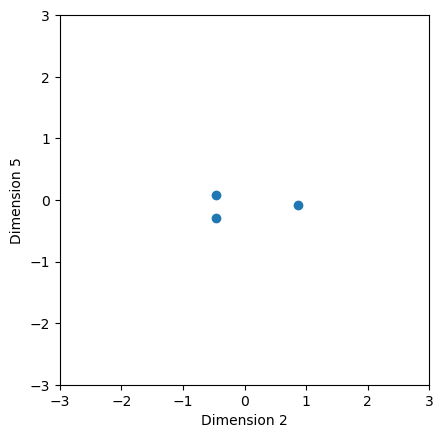

In [20]:
dir_arr = np.asarray(dir_list)
idx = np.random.choice(dir_arr.shape[1], size=2, replace=False) # pick some random dimensions
i, j = idx[0], idx[1]
plt.scatter(x=dir_arr[:, i], y=dir_arr[:, j])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel(f'Dimension {i+1}')
ax.set_ylabel(f'Dimension {j+1}')

In [2]:
from statsmodels.stats.multivariate import mardia

ImportError: cannot import name 'mardia' from 'statsmodels.stats.multivariate' (/Users/admin/opt/anaconda3/envs/env_pytorch/lib/python3.9/site-packages/statsmodels/stats/multivariate.py)

In [9]:
d = 5
K = 5
data_dict = generate_correlated_normal_data(d=d, K=K)
x1, x2 = data_dict['data']
gt_constants = data_dict['alphas']
gt_vecs = data_dict['gt_vecs']
gt_covs = data_dict['gt_covs']

rand_idx = np.random.choice(K)
x1_subset = x1[:, rand_idx*d:(rand_idx+1)*d]
x2_subset = x2[:, rand_idx*d:(rand_idx+1)*d]
aug_cov = (x1_subset.T @ x2_subset) / (x1_subset.shape[0] - 1)
print(f'True joint covariance: {gt_covs[rand_idx]}')
print(f'Self covariances, subset1: {torch.cov(x1_subset.T)}')
print(f'Self covariances, subset2: {torch.cov(x2_subset.T)}')
print(f'Augmentation covariance: {aug_cov}')
print(f'True Augmentation covariance: {gt_covs[rand_idx][:d, d:]}')



True joint covariance: tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          6.1136e-01, -2.0096e-01,  4.7993e-02, -5.8423e-03,  2.1782e-01],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -2.0096e-01,  6.6057e-02, -1.5776e-02,  1.9204e-03, -7.1600e-02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          4.7993e-02, -1.5776e-02,  3.7675e-03, -4.5863e-04,  1.7099e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         -5.8423e-03,  1.9204e-03, -4.5863e-04,  5.5830e-05, -2.0816e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          2.1782e-01, -7.1600e-02,  1.7099e-02, -2.0816e-03,  7.7608e-02],
        [ 6.1136e-01, -2.0096e-01,  4.7993e-02, -5.8423e-03,  2.1782e-01,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-2.0096e-01,  6.6057e-02, -1.5776e-02,  1.9204e-03, -7.1600e-02,
         

In [6]:
rand_idx

1

In [5]:
x1_subset.shape

torch.Size([78036, 1])

Norm of 20 rows of Z1: tensor([2.5218, 2.4438, 3.0197, 3.7792, 2.4956, 3.4087, 2.7014, 2.7252, 2.7118,
        3.3279, 2.8627, 2.7642, 2.8202, 2.7853, 3.2624, 2.5804, 2.5628, 3.5298,
        3.7057, 2.5995])
Norm of 20 rows of Z1: tensor([2.4907, 2.7799, 2.4818, 3.1171, 3.8096, 2.6324, 3.5999, 2.7928, 2.7485,
        3.3102, 3.1067, 3.4943, 2.8242, 2.4572, 2.8470, 3.5745, 2.9016, 2.9537,
        2.4860, 2.4317])
Norm of 20 rows of Z1: tensor([2.4289, 2.5351, 2.4974, 2.3689, 2.1691, 3.4627, 2.1532, 4.1950, 3.7103,
        2.3716, 2.8853, 2.5018, 2.5457, 2.7161, 2.8264, 3.4996, 2.5670, 2.7424,
        3.2578, 2.5921])
Norm of 20 rows of Z1: tensor([3.0088, 2.6081, 3.1112, 2.5616, 2.7448, 2.5848, 2.7266, 2.7826, 3.2732,
        2.3504, 2.8548, 2.3560, 2.8787, 3.2845, 3.0796, 3.3105, 3.5635, 3.0268,
        3.2581, 3.5197])
Norm of 20 rows of Z1: tensor([2.4672, 2.7333, 2.4849, 2.8998, 2.9025, 2.4266, 2.3047, 2.9203, 2.7603,
        2.8554, 2.7482, 2.6578, 3.0609, 2.8993, 2.6878, 2.9616, 2

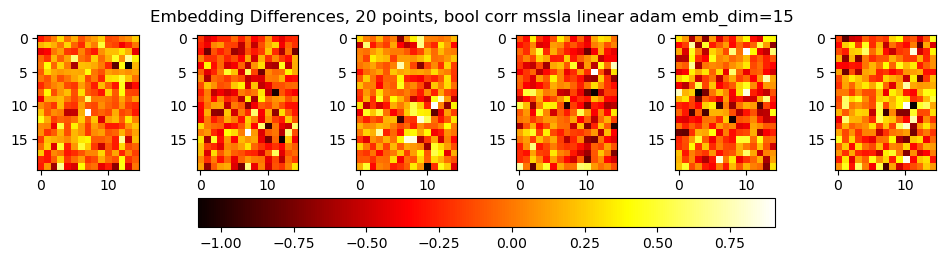

Average Frobenius norm of differences in covariances (6 runs): 0.020617501810193062, embed dim = 15


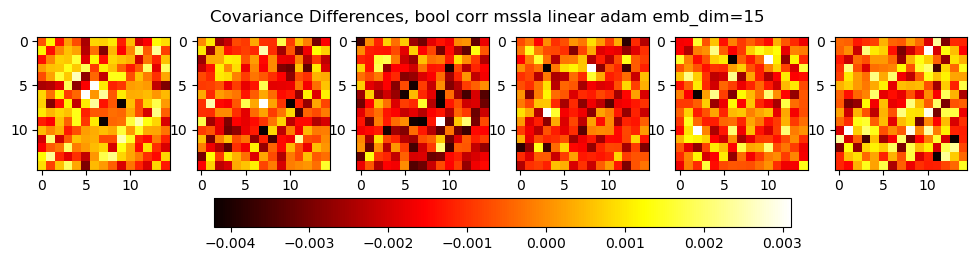

In [ ]:
# MSSL CORR 
dirs = [
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run1',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run2',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run3',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run4',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run5',
'./outputs/embd15_runs/bool_corr_spur/mssla_linear_adam_emb_dim=15_run6',
]
plot_embeddings(dirs, toplot='embds', diff=True, n=20)
plot_embeddings(dirs, toplot='cov', diff=True)

Average norm of differences in embeddings (4 runs): 0.09455543011426926, embed dim = 10


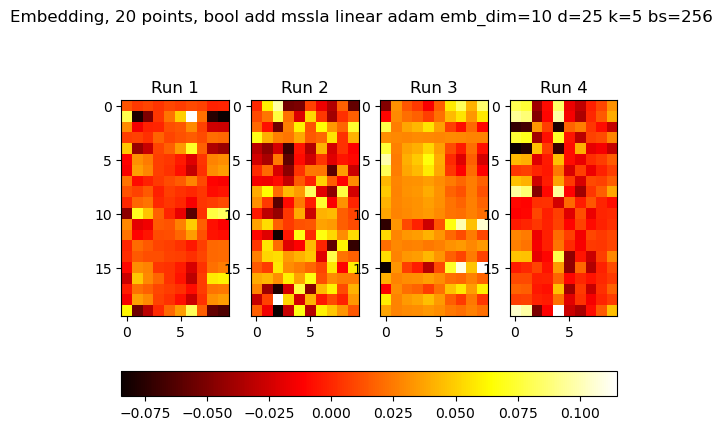

Average Frobenius norm of differences in covariances (4 runs): 0.001541726989671588, embed dim = 10


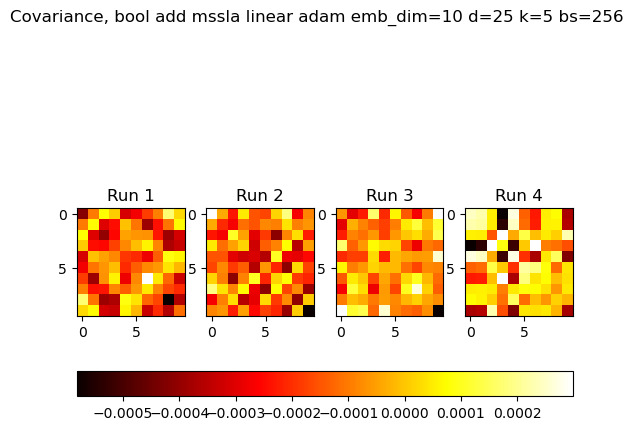

In [ ]:
# MSSL ADD
dirs = [
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/mssla_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

Average norm of differences in embeddings (4 runs): 0.009822060354053974, embed dim = 10


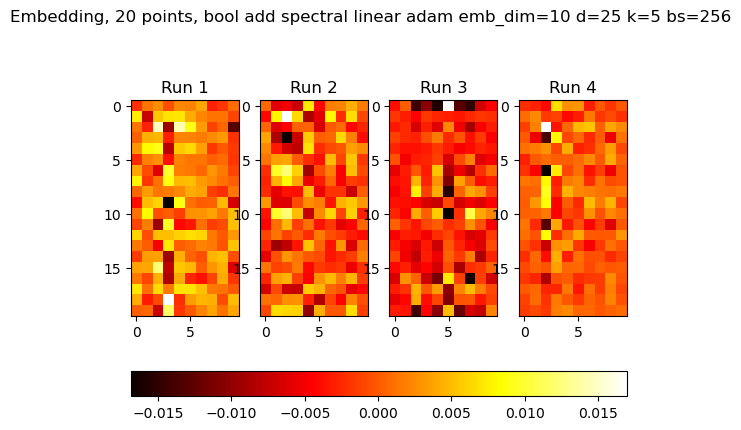

Average Frobenius norm of differences in covariances (4 runs): 0.00014511648623738438, embed dim = 10


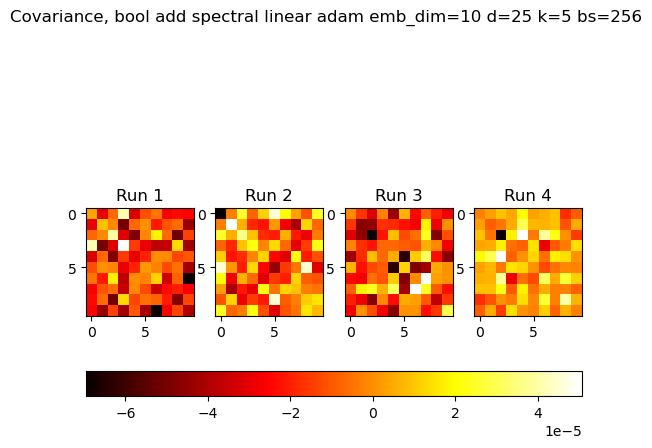

In [ ]:
# SPECTRAL ADD
dirs = [
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run1',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run2',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run3',
'./outputs/bool_add_spur/spectral_linear_adam_emb_dim=10_d=25_k=5_bs=256_run4',
]
plot_embeddings(*dirs, toplot='embds', diff=True, n=20)
plot_embeddings(*dirs, toplot='cov', diff=True)

In [8]:
count = 0
for i in range(1000):
    try:
        generate_correlated_normal_data(n=3, v=0, d=5, K=3)
    except:
        count += 1
count

995

In [19]:
# example: let V = 0.5 = b I,  then we need a = 1 - b^2 = 3/4
# mean = Vx = bx, cov = a xx^T
b = 0.5
a = 1 - (b ** 2)
x = torch.randn(2)
cov = a * x.reshape(2, 1) @ x.reshape(1, 2)
mean = b * x

# cov is rank 1, so sampling from cov is equivalent to sampling from its equivalent 1 dimensional gaussian in 2d

In [20]:
mean, cov

(tensor([-0.6391,  0.8912]),
 tensor([[ 1.2255, -1.7088],
         [-1.7088,  2.3828]]))

In [21]:
D, Q = torch.linalg.eigh(cov)
D[0] = 0
D = torch.sqrt(D)
sqrt = Q @ torch.diag(D) @ Q.T

tensor([-5.9605e-08,  3.6082e+00])

In [31]:
torch.var(x), torch.var(y)

(tensor(0.8857), tensor(1.9815))

In [33]:
torch.mean(y-x)

tensor(0.0744)

In [106]:
count = 0
error_count = 0
d = 5
while count <= 10000:
    vec = torch.randn(d)
    vec = vec / torch.norm(vec)
    # print(f"Vec: {vec}")
    # print(f"Norm of vec: {torch.norm(vec)}")
    outer = torch.outer(vec, vec)
    matrix = torch.eye(2*d)
    matrix[:d, d:] = outer
    matrix[d:, :d] = outer
    try:
        np.linalg.cholesky(matrix)
    except np.linalg.linalg.LinAlgError as err:
        if 'Matrix is not positive definite' in str(err):
            error_count += 1
    count += 1
# things to try: 
# same code as above, since numerical precision can still produce a PD matrix. (but norm(v) wont be exactly 1.)
# use scipy multivariate normal with PSD matrices exactly, confirming that norm(v) = 1 exactly


In [107]:
error_count

4925

In [123]:
d = 5
const = 1
vec = torch.rand(d)
vec = vec / torch.norm(vec)
cov = torch.eye(2*d)
outer = torch.outer(vec, vec)
cov[:d, d:] = const * outer
cov[d:, :d] = const * outer

print(f" PD? {(torch.abs(const * (torch.norm(vec) ** 2)) < 1).item()}")
print(f"Eigenvals: {torch.linalg.eig(cov)[0].real}")

mvn = multivariate_normal(mean=torch.zeros(2*d), cov=cov, allow_singular=True)


 PD? False
Eigenvals: tensor([5.9605e-08, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00])


ValueError: The input matrix must be symmetric positive semidefinite.

In [125]:
torch.norm(vec) ** 2
print(f"Eigenvals: {torch.linalg.eig(cov)[0]}")

Eigenvals: tensor([5.9605e-08+0.j, 1.0000e+00+0.j, 2.0000e+00+0.j, 1.0000e+00+0.j, 1.0000e+00+0.j,
        1.0000e+00+0.j, 1.0000e+00+0.j, 1.0000e+00+0.j, 1.0000e+00+0.j, 1.0000e+00+0.j])


In [109]:
np.linalg.cholesky(cov)

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01624958,  0.06089126,  0.03257396,  0.03020227,  0.05941119,
         0.99525136,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06089126,  0.2281748 ,  0.12206279,  0.11317548,  0.22262865,
        -0.03567357,  0.9304216 ,  0.        